En este notebook, entrenamos modelos de predicción de discursos de odio en base a distintos datasets, para poder predecir su uso en reddit.

In [1]:
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.model_selection import train_test_split


import spacy

from preprocessing_utils import give_emoji_free_text, url_free_text, \
email_free_text, quotes_free_text, get_lemmas, tokenize, preprocess_corpus

nlp = spacy.load("es_core_news_lg")

## Dataset HatEval (SemEval 2019 Task5)

Paper: https://aclanthology.org/S19-2007/

Competencia: https://competitions.codalab.org/competitions/19935

### Descripción

Este dataset consiste en ~7000 Tweets, que posiblemente representen discurso de odio hacia mujeres o inmigrantes.

El dataset está formado por 5 columnas, representando cada una:

1. ID del Tweet.
1. El texto del Tweet.
1. HS (*hate speech*): si el discurso de odio ocurre contra mujeres o inmigrantes.
1. TR (*target*): si HS=1, recibe un valor de 0 si el discurso de odio es contra un grupo genérico, o un valor de 1 si es específicamente contra un individuo.
1. AG (*aggresive*): si HS=1, indica si quien escribe el Tweet exhibe comportamiento agresivo (si es así: 1; en caso contrario: 0).

([fuente](https://competitions.codalab.org/competitions/19935#participate))


In [2]:
verbose = 0

In [3]:
# cargamos el dataset y vemos su información

hate_eval = pd.read_csv('docs/hateval2019/hateval2019_es_train.csv')
print(hate_eval.describe())

                id           HS           TR           AG
count   4500.00000  4500.000000  4500.000000  4500.000000
mean   22507.03400     0.412667     0.250889     0.333778
std     1444.00945     0.492369     0.433573     0.471614
min    20001.00000     0.000000     0.000000     0.000000
25%    21263.50000     0.000000     0.000000     0.000000
50%    22509.50000     0.000000     0.000000     0.000000
75%    23759.25000     1.000000     1.000000     1.000000
max    25000.00000     1.000000     1.000000     1.000000


In [4]:
if verbose:
    print(hate_eval[hate_eval['HS']==1])

In [5]:
print('Cantidad de Tweets sin HS: {} \nCantidad de Tweets con HS: {}'.format(
    len(hate_eval[hate_eval['HS']==0]), len(hate_eval[hate_eval['HS']==1])))

Cantidad de Tweets sin HS: 2643 
Cantidad de Tweets con HS: 1857


In [6]:
print(hate_eval['id'])

0       20001
1       20002
2       20003
3       20004
4       20007
        ...  
4495    24996
4496    24997
4497    24998
4498    24999
4499    25000
Name: id, Length: 4500, dtype: int64


## Dataset Detoxis (SemEval **TODO**)

Paper: **TODO**

Competencia: **TODO**

### Descripción

Este dataset consiste en **TODO**.

El dataset está formado por **TODO** columnas, representando cada una:

1. **TODO**.


In [7]:
# cargamos detoxis dataset

detoxis = pd.read_csv('docs/detoxis_data/train.csv')
print(detoxis.describe())

       comment_level  argumentation  constructiveness  positive_stance  \
count    3463.000000    3463.000000       3463.000000      3463.000000   
mean        1.599191       0.460295          0.275772         0.030898   
std         0.491310       0.498493          0.446967         0.173067   
min         0.000000       0.000000          0.000000         0.000000   
25%         1.000000       0.000000          0.000000         0.000000   
50%         2.000000       0.000000          0.000000         0.000000   
75%         2.000000       1.000000          1.000000         0.000000   
max         3.000000       1.000000          1.000000         1.000000   

       negative_stance  target_person  target_group   stereotype      sarcasm  \
count      3463.000000    3463.000000   3463.000000  3463.000000  3463.000000   
mean          0.178169       0.143806      0.145250     0.094138     0.117817   
std           0.382710       0.350944      0.352403     0.292063     0.322438   
min      

In [8]:
if verbose:
    print(detoxis[detoxis['negative_stance']==1])

## Dataset MeOffendEs (Iberlef **TODO**)

Paper: **TODO**

Competencia: **TODO**

### Descripción

Este dataset consiste en .

El dataset está formado por **TODO** columnas, representando cada una:

1. **TODO**


In [9]:
# cargamos MeOffendEs dataset

meoffendes = pd.read_csv('docs/detoxis_data/train.csv')
print(detoxis.describe())

       comment_level  argumentation  constructiveness  positive_stance  \
count    3463.000000    3463.000000       3463.000000      3463.000000   
mean        1.599191       0.460295          0.275772         0.030898   
std         0.491310       0.498493          0.446967         0.173067   
min         0.000000       0.000000          0.000000         0.000000   
25%         1.000000       0.000000          0.000000         0.000000   
50%         2.000000       0.000000          0.000000         0.000000   
75%         2.000000       1.000000          1.000000         0.000000   
max         3.000000       1.000000          1.000000         1.000000   

       negative_stance  target_person  target_group   stereotype      sarcasm  \
count      3463.000000    3463.000000   3463.000000  3463.000000  3463.000000   
mean          0.178169       0.143806      0.145250     0.094138     0.117817   
std           0.382710       0.350944      0.352403     0.292063     0.322438   
min      

In [10]:
if verbose:
    pass

# Procesamos y entrenamos cada uno de los datasets

Definimos la función general de entrenamiento, que lee un conjunto de datos, lo vectoriza y entrena un modelo a partir de dicha vectorización, mostrando las métricas generales del mismo.

In [11]:
def process_training_pipeline(dataset, vectorizer, labels, model):
    vectorized_corpus = vectorizer.fit_transform(dataset)
    X_tr, X_val, y_tr, y_val = train_test_split(vectorized_corpus, labels, test_size=0.3, random_state=42)
    model.fit(X_tr, y_tr)

    print('Tasa de aciertos del clasificador: {} (train), {} (val)'.format(model.score(X_tr, y_tr),
                                                                  model.score(X_val, y_val)))
    print('\nMétricas (train)')
    #print(classification_report(X_tr, y_tr))
    print('Matriz de confusión (train)')
    plot_confusion_matrix(model, X_tr, y_tr,
                          cmap=plt.cm.Blues, 
                          normalize='true')
    plt.show()
    print('\nMétricas (val)')
    #print(classification_report(X_val, y_val))
    print('Matriz de confusión (val)')
    plot_confusion_matrix(model, X_val, y_val,
                          cmap=plt.cm.Blues, 
                          normalize='true')
    plt.show()
    

### Hateval dataset

In [12]:
hateval_corpus_lines = preprocess_corpus(hate_eval['text'])

In [13]:
y_hateval = hate_eval['HS'].values

In [14]:
cv_hateval = CountVectorizer(ngram_range=(1, 3), min_df=10)
lg_hateval = LogisticRegression(random_state=42)
nb_hateval = ComplementNB()
rf_hateval = RandomForestClassifier(random_state=42)

Tasa de aciertos del clasificador: 0.9257142857142857 (train), 0.8051851851851852 (val)

Métricas (train)
Matriz de confusión (train)


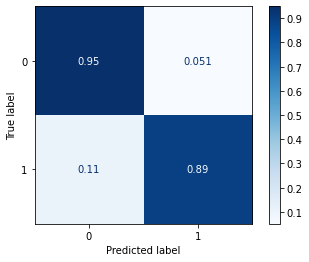


Métricas (val)
Matriz de confusión (val)


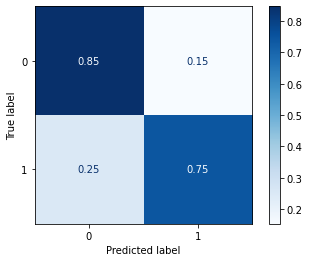

In [15]:
process_training_pipeline(hateval_corpus_lines, 
                          cv_hateval,
                          y_hateval,
                          lg_hateval
                         )

Tasa de aciertos del clasificador: 0.9996825396825397 (train), 0.8007407407407408 (val)

Métricas (train)
Matriz de confusión (train)


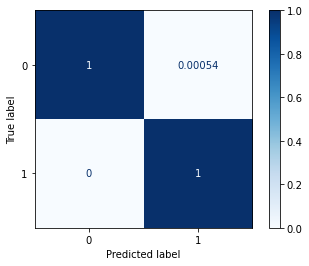


Métricas (val)
Matriz de confusión (val)


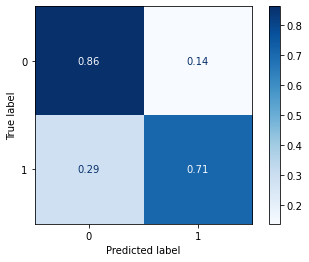

In [16]:
process_training_pipeline(hateval_corpus_lines, 
                          cv_hateval,
                          y_hateval,
                          rf_hateval
                         )

Tasa de aciertos del clasificador: 0.8368253968253968 (train), 0.7703703703703704 (val)

Métricas (train)
Matriz de confusión (train)


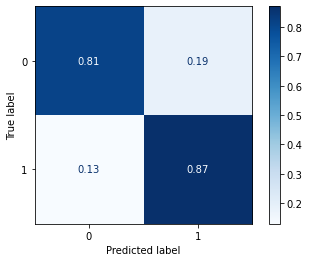


Métricas (val)
Matriz de confusión (val)


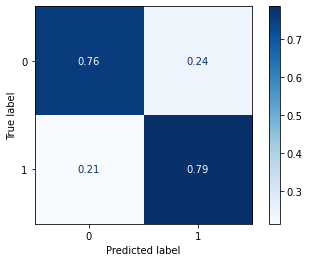

In [17]:
process_training_pipeline(hateval_corpus_lines, 
                          cv_hateval,
                          y_hateval,
                          nb_hateval
                         )

In [18]:
if verbose:
    print(cv_hateval.get_feature_names()[:5])

In [19]:
# obtenemos las características que más aportan a la clasificación del modelo random forest
rf_features_hateval_idx = rf_hateval.feature_importances_.argsort()[::-1]

if verbose:
    print(np.array(cv_hateval.get_feature_names())[rf_features_hateval_idx[:30]])
    print(rf_hateval.feature_importances_[rf_features_hateval_idx[:30]])

In [20]:
# guardamos el vectorizador y un modelo entrenado

with open('hateval_vectorizer.pkl', 'wb') as file:
    pickle.dump(cv_hateval, file)

with open('hateval_nb_model.pkl', 'wb') as file:
    pickle.dump(nb_hateval, file)
    

## Detoxis dataset

In [21]:
detoxis_corpus_lines = preprocess_corpus(detoxis['comment'])
y_detoxis = detoxis['aggressiveness']

In [22]:
y_detoxis[detoxis['aggressiveness']==1]

2       1
5       1
10      1
29      1
32      1
       ..
3280    1
3288    1
3289    1
3291    1
3295    1
Name: aggressiveness, Length: 114, dtype: int64

In [23]:
cv_detoxis = CountVectorizer(ngram_range=(1, 3), min_df=10)
lg_detoxis = LogisticRegression(random_state=42)
nb_detoxis = ComplementNB()
rf_detoxis = RandomForestClassifier(random_state=42)

Tasa de aciertos del clasificador: 0.9913366336633663 (train), 0.958614051973051 (val)

Métricas (train)
Matriz de confusión (train)


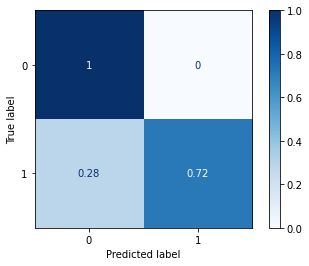


Métricas (val)
Matriz de confusión (val)


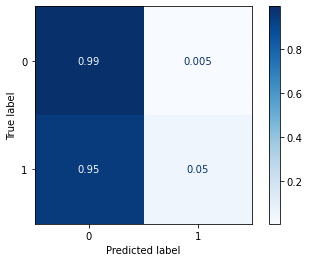

In [24]:
process_training_pipeline(detoxis_corpus_lines, 
                          cv_detoxis,
                          y_detoxis,
                          lg_detoxis
                         )

Tasa de aciertos del clasificador: 0.9995874587458746 (train), 0.9615014436958614 (val)

Métricas (train)
Matriz de confusión (train)


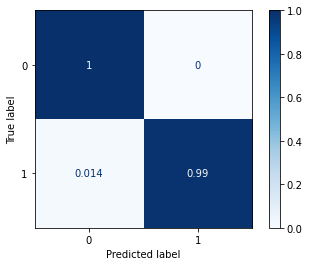


Métricas (val)
Matriz de confusión (val)


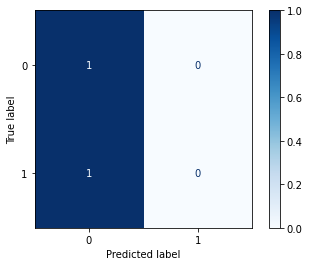

In [25]:
process_training_pipeline(detoxis_corpus_lines, 
                          cv_detoxis,
                          y_detoxis,
                          rf_detoxis
                         )

Tasa de aciertos del clasificador: 0.9125412541254125 (train), 0.8585178055822906 (val)

Métricas (train)
Matriz de confusión (train)


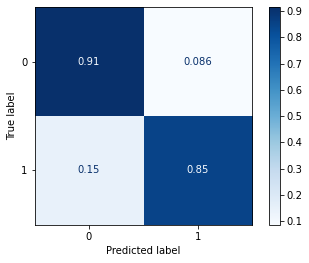


Métricas (val)
Matriz de confusión (val)


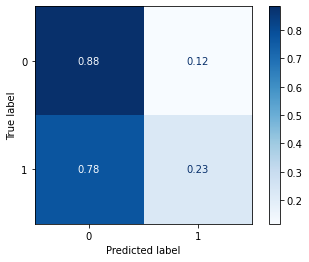

In [26]:
process_training_pipeline(detoxis_corpus_lines, 
                          cv_detoxis,
                          y_detoxis,
                          nb_detoxis
                         )

In [27]:
# obtenemos las características que más aportan a la clasificación del modelo random forest
rf_features_detoxis_idx = rf_detoxis.feature_importances_.argsort()[::-1]

if verbose:
    print(np.array(cv_detoxis.get_feature_names())[rf_features_detoxis_idx[:30]])
    print(rf_detoxis.feature_importances_[rf_features_detoxis_idx[:30]])

## MeOffendEs dataset

In [28]:
cv_meoffendes = CountVectorizer(ngram_range=(1, 3), min_df=10)
lg_meoffendes = LogisticRegression(random_state=42)
nb_meoffendes = ComplementNB()
rf_meoffendes = RandomForestClassifier(random_state=42)

# Prueba de modelos en Reddit con Hateval

In [29]:
df = pd.read_csv('docs/preprocessing_reddit_data.csv')

if verbose:
    print(df)

In [30]:
df_reddit_original = pd.read_csv('docs/reddit_data.csv')

In [31]:
reddit_corpus = preprocess_corpus(df['body'].astype('str'))
reddit_adapted = cv_hateval.transform(reddit_corpus)

In [32]:
reddit_predictions = nb_hateval.predict(reddit_adapted)
reddit_hs_proba = nb_hateval.predict_proba(reddit_adapted)[:,1]
print(reddit_hs_proba)

[0.5        0.17581837 0.5        ... 0.5        0.6700017  0.5       ]


In [33]:
target_predict_proba = 0.8
hate_mask = reddit_hs_proba>=target_predict_proba
print(len(hate_mask))

35134


In [34]:
df_reddit_original[hate_mask].to_csv('test_reddit_hateval_hate_comments.csv')

# Mejoras a realizar

* Optimizar híper-parámetros.
* Hacer un ensemble de clasificadores.
* **TODO**

FIN